### Notebook for plotting the figures for the Adaptation section

In [3]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import pandas as pd
import rasterio
import geopandas as gpd
import pycountry
import numpy as np
import yaml
import os
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
import matplotlib.patches as mpatches
import matplotlib as mpl
from adjustText import adjust_text

In [4]:
# Set paths
baseline_path = r"C:\Users\Mark.DESKTOP-UFHIN6T\Projects\flood-wealth\data\results\flood_risk\summary\countries\THA\THA_ADM2_metrics_jrc-flood_AALs_baseline_capstock.gpkg"
adapted_path = r"C:\Users\Mark.DESKTOP-UFHIN6T\Projects\flood-wealth\data\results\flood_risk\summary\countries\THA\THA_ADM2_metrics_jrc-flood_AALs_adapted_fp_rp100_duc30_capstock.gpkg"
cost_path = r"C:\Users\Mark.DESKTOP-UFHIN6T\Projects\flood-wealth\data\results\adaptation\costs\countries\THA\THA_adaptation-cost_fp_rp100_duc30_ADM2.gpkg"

In [37]:
# Load data
baseline = gpd.read_file(baseline_path)
adapted = gpd.read_file(adapted_path)
cost = gpd.read_file(cost_path)
# Adjust cost from millions to actual value
cost['adaptation_cost']*=1e6
cost['adj_adaptation_cost']*=1e6

In [47]:
# BCR function
def calculate_bcr(baseline_df, adapted_df, cost_df, time_period=20, discount_rate=0.03):
    # merge all dataframes on shapename
    merged_df = baseline_df[['shapeName', 'total_losses']].merge(
        adapted_df[['shapeName', 'total_losses']],
        on='shapeName',
        suffixes=('_baseline', '_adapted')
    ).merge(
        cost_df[['shapeName', 'adaptation_cost']],
        on='shapeName'
    )
    # Calculate actual benefits
    merged_df['annual_benefits'] = (
        merged_df['total_losses_baseline'] -
        merged_df['total_losses_adapted']
    )
    # Calculate present value of benefits over time period
    if discount_rate ==0:
        pv_factor = time_period
    else:
        pv_factor = (1-(1 + discount_rate)** -time_period) / discount_rate
    merged_df['pv_benefits'] = merged_df['annual_benefits'] * pv_factor
    # Calculate benefit-cost ratio
    merged_df['bcr'] = merged_df['pv_benefits'] / merged_df['adaptation_cost']
    # Handle division by 0 or negative costs
    merged_df['bcr'] = merged_df['bcr'].replace([np.inf, -np.inf], np.nan)
    # Create results dataframe
    results_df = merged_df[[
        'shapeName',
        'annual_benefits',
        'pv_benefits',
        'adaptation_cost',
        'bcr'
    ]]
    # Pull geometry
    results_gdf = baseline_df[['shapeName', 'geometry']].merge(
        results_df,
        on='shapeName',
        how='right'
    )

    return results_gdf

In [48]:
results = calculate_bcr(baseline, adapted, cost, time_period=20, discount_rate=0.03)

In [49]:
results.sort_values('bcr', ascending=False)[:60]

,shapeName,geometry,annual_benefits,pv_benefits,adaptation_cost,bcr
1086,Mueang Nonthaburi,"MULTIPOLYGON (((100.44793 13.86738, 100.44896 ...",1.787658e+08,2.659584e+09,6.252237e+07,42.538121
1244,Pak Kret,"MULTIPOLYGON (((100.44958 13.88909, 100.44844 ...",1.067473e+08,1.588130e+09,4.447563e+07,35.707863
1088,Mueang Pathum Thani,"MULTIPOLYGON (((100.60658 13.95436, 100.60419 ...",1.652668e+08,2.458752e+09,8.068865e+07,30.472092
1075,Mueang Mukdahan,"MULTIPOLYGON (((104.74199 16.62628, 104.74168 ...",2.972115e+07,4.421757e+08,2.193444e+07,20.158974
59,Bang Kruai,"MULTIPOLYGON (((100.42763 13.83389, 100.42856 ...",9.850760e+06,1.465544e+08,1.507080e+07,9.724395
1085,Mueang Nong Khai,"MULTIPOLYGON (((102.6718 17.8033, 102.67491 17...",8.225760e+06,1.223785e+08,1.465197e+07,8.352362
1311,Phra Pradaeng,"MULTIPOLYGON (((100.58876 13.68305, 100.58762 ...",1.156881e+08,1.721146e+09,2.550284e+08,6.748843
1074,Mueang Maha Sarakham,"MULTIPOLYGON (((103.24882 15.97607, 103.24654 ...",1.323601e+07,1.969184e+08,3.026943e+07,6.505518
1108,Mueang Samut Sakhon,"MULTIPOLYGON (((100.05317 13.48581, 100.0541 1...",4.098237e+07,6.097142e+08,9.737177e+07,6.261714
908,Khlong Sam Wa,"MULTIPOLYGON (((100.67544 13.85642, 100.67658 ...",3.955139e+07,5.884248e+08,9.441283e+07,6.232466


In [50]:
# Plot
# Simple plotting function
def plot_bcr_map(bcr_gdf, figsize=(12, 8)):
    """
    Plot BCR results on a map.
    """
    fig, ax = plt.subplots(figsize=figsize)
    
    # Plot BCR with color mapping
    bcr_gdf.plot(
        column='bcr',
        cmap='RdYlGn',  # Red-Yellow-Green colormap (red=low BCR, green=high BCR)
        legend=True,
        ax=ax,
        edgecolor='black',
        linewidth=0.5,
        missing_kwds={'color': 'lightgray'}  # Color for NaN values
    )
    
    ax.set_title('Benefit-Cost Ratio by Region', fontsize=14, fontweight='bold')
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    
    # Add horizontal line at BCR = 1 in legend if needed
    plt.tight_layout()
    return fig, ax

(<Figure size 1200x800 with 2 Axes>,
 <Axes: title={'center': 'Benefit-Cost Ratio by Region'}, xlabel='Longitude', ylabel='Latitude'>)

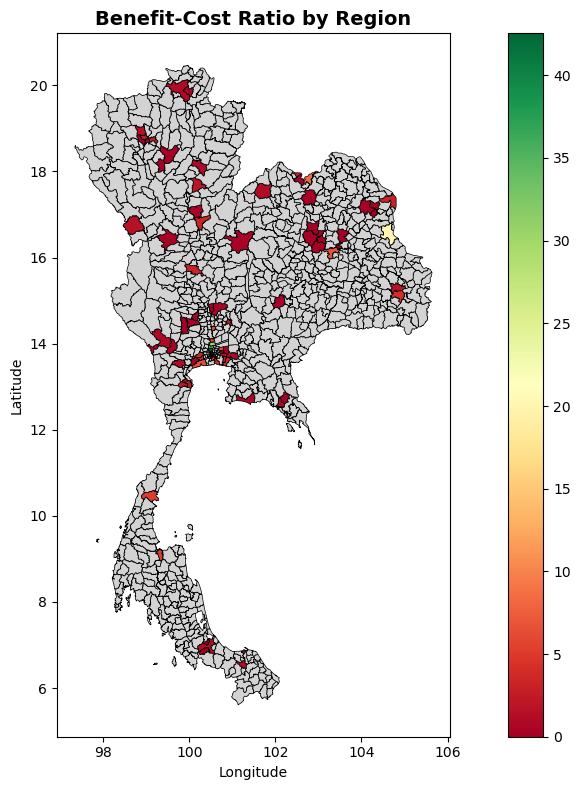

In [51]:
plot_bcr_map(results)